# Analyzing speed of light measurements

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">
This notebook is an element of the [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>. 

---

This notebook contains an introduction to use of Python and SciPy to analyze historical measurements of the speed of light, an important quest in physics. It includes an introduction to the use of **bootstrap resampling** to generate confidence intervals for a measure. The [associated lecture slides](https://risk-engineering.org/static/PDF/slides-data-analysis.pdf) provide relevant background information.

In [1]:
import numpy
import scipy.stats
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats=['svg']

Our discussion in this notebook is partially based on information from the article by R. J. MacKay and R. W. Oldford, *Scientific Method, Statistical Method and the Speed of Light*, Statistical Science, 2000, 15:3, pp. 254–278 ([available from Project Euclid](https://projecteuclid.org/download/pdf_1/euclid.ss/1009212817)), and on a discussion of successive measurements of the speed of light by S. Prokhovnik and W. Morris, *A review of speed of light measurements since 1676*, CEN Tech. J. 1993, 7:2, pp. 181–183. 

Around 1879, an instructor in physics at the U.S. Naval Academy in Annapolis, A. Michelson, undertook to measure the speed of light, using an adaptation of Foucault's rotating mirror approach. He made around 100 measurements, which you can [download in CSV format](https://risk-engineering.org/static/data/michelson-speed-light.csv).

In [2]:
mich = pandas.read_csv("https://risk-engineering.org/static/data/michelson-speed-light.csv")
mich.rename(columns={'velocity of light in air (km/s)': 'speed'}, inplace=True)
mich.head()

,Unnamed: 0,date,distinctness of image,temperature (F),position of deflected image,position of slit,displacement of image in divisions,difference between greatest and least,B,Cor,revolutions per second,radius (ft),value of one turn of screw,speed,remarks
0,0,June 5,3,76,114.85,0.300,114.55,0.17,1.423,-0.132,257.36,28.672,0.99614,299850,Electric light.
1,1,June 7,2,72,114.64,0.074,114.56,0.10,1.533,-0.084,257.52,28.655,0.99614,299740,P.M. Frame inclined at various angles
2,2,June 7,2,72,114.58,0.074,114.50,0.08,1.533,-0.084,257.52,28.647,0.99614,299900,P.M. Frame inclined at various angles
3,3,June 7,2,72,85.91,0.074,85.84,0.12,1.533,-0.084,193.14,28.647,0.99598,300070,P.M. Frame inclined at various angles
4,4,June 7,2,72,85.97,0.074,85.89,O.07,1.533,-0.084,193.14,28.650,0.99598,299930,P.M. Frame inclined at various angles


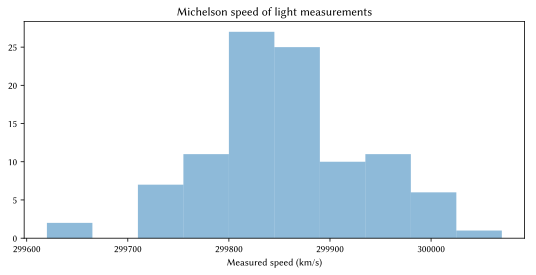

In [3]:
plt.figure(figsize=(9, 4))
plt.xlabel("Measured speed (km/s)")
plt.title("Michelson speed of light measurements")
plt.hist(mich.speed, alpha=0.5);

The mean value from Michelson’s measurements is

In [4]:
mich.speed.mean()

299852.4

Since there is clearly some measurement uncertainty, we would like to report a **95% confidence interval** for the measurements. We can do this using bootstrap resampling, as implemented in the function below.

In [5]:
def bootstrap_confidence_intervals(data, estimator, percentiles, runs=1000):
    replicates = numpy.empty(runs)
    for i in range(runs):
        replicates[i] = estimator(numpy.random.choice(data, len(data), replace=True))
    est = numpy.mean(replicates)
    ci = numpy.percentile(replicates, percentiles)
    return (est, ci)

In [6]:
est, ci = bootstrap_confidence_intervals(mich.speed, estimator=numpy.mean, percentiles=[2.5, 97.5])
est, ci

(299852.6312, array([299836.095 , 299869.2025]))

In [7]:
est - ci[0], ci[1] - est

(16.536200000031386, 16.571300000010524)

The first return value is the bootstrapped estimate of the mean, and the second return value is the 95% confidence interval. Given that the confidence interval is roughly symmetrical, we could report this measurement as

    299853 ± 16 km/s (95% CI) 

or as 

    2998523 [299837, 299869] km/s (95% CI). 

Note that a “naked” ± notation for the margin of error is ambiguous, as is a simple interval, because some technical communities use one or two standard deviations instead of a confidence interval. 

At the time, Michelson made a few corrections to his measurements to account for the influence of temperature, and accounting for a number of sources of uncertainty in his measurement method,  reported his estimate of the speed of light in a vacuum as

    299944 ± 51 km/s

Just three years later in 1882, Simon Newcomb ran another experiment to measure the speed of light. He measured the time required for light to travel from his laboratory on the
Potomac river to a mirror at the base of the Washington Monument and back, a total distance of about 7400 meters. The data are recorded as deviations from 24800 nanoseconds. They were measured on three different days. The “raw” measurements are given below.

In [8]:
newcomb1 = [28, -44, 29, 30, 26, 27, 22, 23, 33, 16, 24, 29, 24, 40, 21, 31, 34, -2, 25, 19]
newcomb2 = [24, 28, 37, 32, 20, 25, 25, 36, 36, 21, 28, 26, 32, 28, 26, 30, 36, 29, 30, 22]
newcomb3 = [36, 27, 26, 28, 29, 23, 31, 32, 24, 27, 27, 27, 32, 25, 28, 27, 26, 24, 32, 29, 28, 33, 39, 25, 16, 23]

To transform from these units into the speed of light expressed in km/s, we use the following transformation:

In [9]:
def newcomb_transform(x):
    return 1000000 * 7.44373 / (x*0.001+24.8)

newcomb1t = newcomb_transform(numpy.array(newcomb1))
newcomb2t = newcomb_transform(numpy.array(newcomb2))
newcomb3t = newcomb_transform(numpy.array(newcomb3))

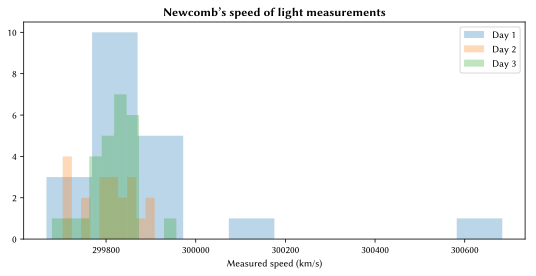

In [10]:
plt.figure(figsize=(9, 4))
plt.hist(newcomb1t, bins=10, alpha=0.3, label="Day 1")
plt.hist(newcomb2t, bins=10, alpha=0.3, label="Day 2")
plt.hist(newcomb3t, bins=10, alpha=0.3, label="Day 3")
plt.legend()
plt.xlabel("Measured speed (km/s)")
plt.title("Newcomb’s speed of light measurements", weight='bold');

We see that the observations from the three days do seem compatible, even if the data from the first day have a larger degree of variance (uncertainty). In fact, there are two **apparent outliers** in the untransformed data (the two negative values). Newcomb decided to discard the measurement of -44, treating it as an outlier (note that there is no magical method for treating outliers in statistical analysis, and the decision to exclude an observation or measurement should not be taken lightly since it may have a significant effect on statistical analyses). 

We also exclude the measurement of -44 and calculate a bootstrap mean and 95% confidence intervals for these observations.

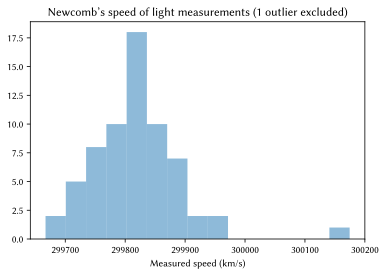

In [11]:
newcomb1.remove(-44)
newcomb_all = numpy.concatenate([newcomb_transform(numpy.array(newcomb1)), newcomb2t, newcomb3t])
# a histogram of all non-outlier measurements
plt.hist(newcomb_all, bins=15, alpha=0.5)
plt.title("Newcomb’s speed of light measurements (1 outlier excluded)")
plt.xlabel("Measured speed (km/s)");

In [12]:
est, ci = bootstrap_confidence_intervals(newcomb_all, numpy.mean, [2.5, 97.5])
est, ci

(299820.88538300345, array([299803.93076305, 299838.54437799]))

In [13]:
est - ci[0], ci[1] - est

(16.95461994886864, 17.658994987083133)

The uncertainty is not quite symmetrical, so we would prefer to report this result as

    299821 [299804, 299840] km/s (95% CI)

It is interesting to note that the defined true value, 299792.458 km/s, is well outside both the
confidence interval for both these sets of measurements. (We don’t know of any good reason for this.)
